# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr. `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import xarray as xr
import pymp
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/scripts/functions")
from mandyocIO import read_datasets, change_dataset, plot_property, find_nearest, plot_tracked_particles, _extract_interface

In [18]:
def get_crustal_domains_coords(dataset, instant, x_spread_center):
    """"
    Function to extract the coordinates of the crustal domains in the necking and hyperextended regions.
    
    Parameters:
    -----------
    dataset: xarray dataset
        Dataset containing the density field.
    instant: float
        Time instant to extract the crustal domains.
    x_spread_center: float
        Center of the spreading axis.

    Returns:
    --------
    xi_necking_left: float
        Initial x coordinate of the necking region on the left margin.
    xf_necking_left: float  
        Final x coordinate of the necking region on the left margin.
    xi_hyperextended_left: float
        Initial x coordinate of the hyperextended region on the left margin.
    xf_hyperextended_left: float
        Final x coordinate of the hyperextended region on the left margin.
    xi_necking_right: float
        Initial x coordinate of the necking region on the right margin.
    xf_necking_right: float
        Final x coordinate of the necking region on the right margin.
    xi_hyperextended_right: float
        Initial x coordinate of the hyperextended region on the right margin.
    xf_hyperextended_right: float
        Final x coordinate of the hyperextended region on the right margin.    
    """

    Lx = float(dataset.lx)
    Lz = float(dataset.lz)
    Nz = int(dataset.nz)
    Nx = int(dataset.nx)

    x = np.linspace(0, Lx/1000.0, Nx)
    z = np.linspace(-Lz/1000.0, 0, Nz)
    Z = np.linspace(-Lz/1000.0, 0, 8001) #zi

    idx = find_nearest(dataset.time, instant)
    Rhoi = dataset.density.isel(time=idx).values.T

    h_air = 40.0
    topography_interface = _extract_interface(z, Z, Nx, Rhoi, 200.) + h_air
    lower_interface = _extract_interface(z, Z, Nx, Rhoi, 2900.) + h_air
    crustal_thickness = np.abs(topography_interface - lower_interface)

    x_spread_center = 700

    #left margin
    cond_left_margin = (x > 0) & (x < x_spread_center)
    x_left = x[cond_left_margin]

    left_crustal_thickness = crustal_thickness[cond_left_margin]

    cond_left_necking = (left_crustal_thickness < 34) & (left_crustal_thickness >= 15)
    cond_left_hyperextension = (left_crustal_thickness < 15) & (left_crustal_thickness >= 2)

    # right margin
    cond_right_margin = (x > x_spread_center) & (x < Lx/1000.0)
    x_right = x[cond_right_margin]

    right_crustal_thickness = crustal_thickness[cond_right_margin]

    cond_right_necking = (right_crustal_thickness < 34) & (right_crustal_thickness >= 15)
    cond_right_hyperextension = (right_crustal_thickness < 15) & (right_crustal_thickness >= 2)

    xi_necking_left = x_left[cond_left_necking][0]
    xf_necking_left = x_left[cond_left_necking][-1]

    xi_hyperextended_left = x_left[cond_left_hyperextension][0]
    xf_hyperextended_left = x_left[cond_left_hyperextension][-1]

    xi_necking_right = x_right[cond_right_necking][-1]
    xf_necking_right = x_right[cond_right_necking][0]

    xi_hyperextended_right = x_right[cond_right_hyperextension][-1]
    xf_hyperextended_right = x_right[cond_right_hyperextension][0]

    return xi_necking_left, xf_necking_left, xi_hyperextended_left, xf_hyperextended_left, xi_necking_right, xf_necking_right, xi_hyperextended_right, xf_hyperextended_right


# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

In [19]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/Volumes/{external_media}"

v = 1
# v = 2

print(f"Rifting velocity: {v} cm/yr")

if(v==1):
    scenarios = [
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc10_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc10_checkered_false",
                ]

if(v==2):
    scenarios = [
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc10_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc10_checkered_false",
                ]

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
             'strain_rate',
            #  'temperature',
            #  'temperature_anomaly',
            #  'surface',
            #  'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True

if ('surface' not in properties): #used to plot air/curst interface
        properties.append('surface')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('surface')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in new_datasets):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')

# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in new_datasets):
        properties.append('pressure')
    if ('temperature' not in new_datasets):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('pressure')
    to_remove.append('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)
dataset2 = read_datasets(scenarios[2], new_datasets)
dataset3 = read_datasets(scenarios[3], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset2.data_vars:
    v_max = np.max((dataset2.velocity_x**2 + dataset2.velocity_z**2)**(0.5))    
    dataset2.velocity_x[:] = dataset2.velocity_x[:] / v_max
    dataset2.velocity_z[:] = dataset2.velocity_z[:] / v_max


Nx = int(dataset0.nx)
Nz = int(dataset0.nz)
Lx = float(dataset0.lx)
Lz = float(dataset0.lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(f"\n{dataset0.info}")

trackdataset0 = xr.open_dataset(f"{scenarios[0]}/_track_xzPT_all_steps.nc")
trackdataset1 = xr.open_dataset(f"{scenarios[1]}/_track_xzPT_all_steps.nc")
trackdataset2 = xr.open_dataset(f"{scenarios[2]}/_track_xzPT_all_steps.nc")
trackdataset3 = xr.open_dataset(f"{scenarios[3]}/_track_xzPT_all_steps.nc")

Rifting velocity: 1 cm/yr

<bound method Dataset.info of <xarray.Dataset> Size: 840MB
Dimensions:      (x: 1001, z: 301, time: 87)
Coordinates:
  * x            (x) float64 8kB 0.0 1e+03 2e+03 ... 9.98e+05 9.99e+05 1e+06
  * z            (z) float64 2kB -3e+05 -2.99e+05 -2.98e+05 ... -1e+03 0.0
  * time         (time) float64 696B 0.0 0.5 1.0 1.5 ... 38.59 39.08 39.52 39.93
    step         (time) int32 348B 0 100 200 300 400 ... 8300 8400 8500 8600
Data variables:
    strain       (time, x, z) float64 210MB ...
    density      (time, x, z) float64 210MB ...
    strain_rate  (time, x, z) float64 210MB ...
    surface      (time, x) float64 697kB ...
    temperature  (time, x, z) float64 210MB ...
Attributes: (12/95)
    nx:                                1001
    nz:                                301
    lx:                                1000000.0
    lz:                                300000.0
    multigrid:                         1
    solver:                            direct
  

A: necking left:[385.0, 522.0], hyperextended left:[523.0, 574.0], necking right:[999.0, 861.0], hyperextended right:[860.0, 721.0]
B: necking left:[1.0, 543.0], hyperextended left:[544.0, 565.0], necking right:[965.0, 853.0], hyperextended right:[852.0, 806.0]
C: necking left:[385.0, 533.0], hyperextended left:[534.0, 677.0], necking right:[999.0, 884.0], hyperextended right:[883.0, 831.0]
D: necking left:[1.0, 526.0], hyperextended left:[527.0, 574.0], necking right:[951.0, 852.0], hyperextended right:[851.0, 701.0]
RHvsRT_symmetries_v1_lithology


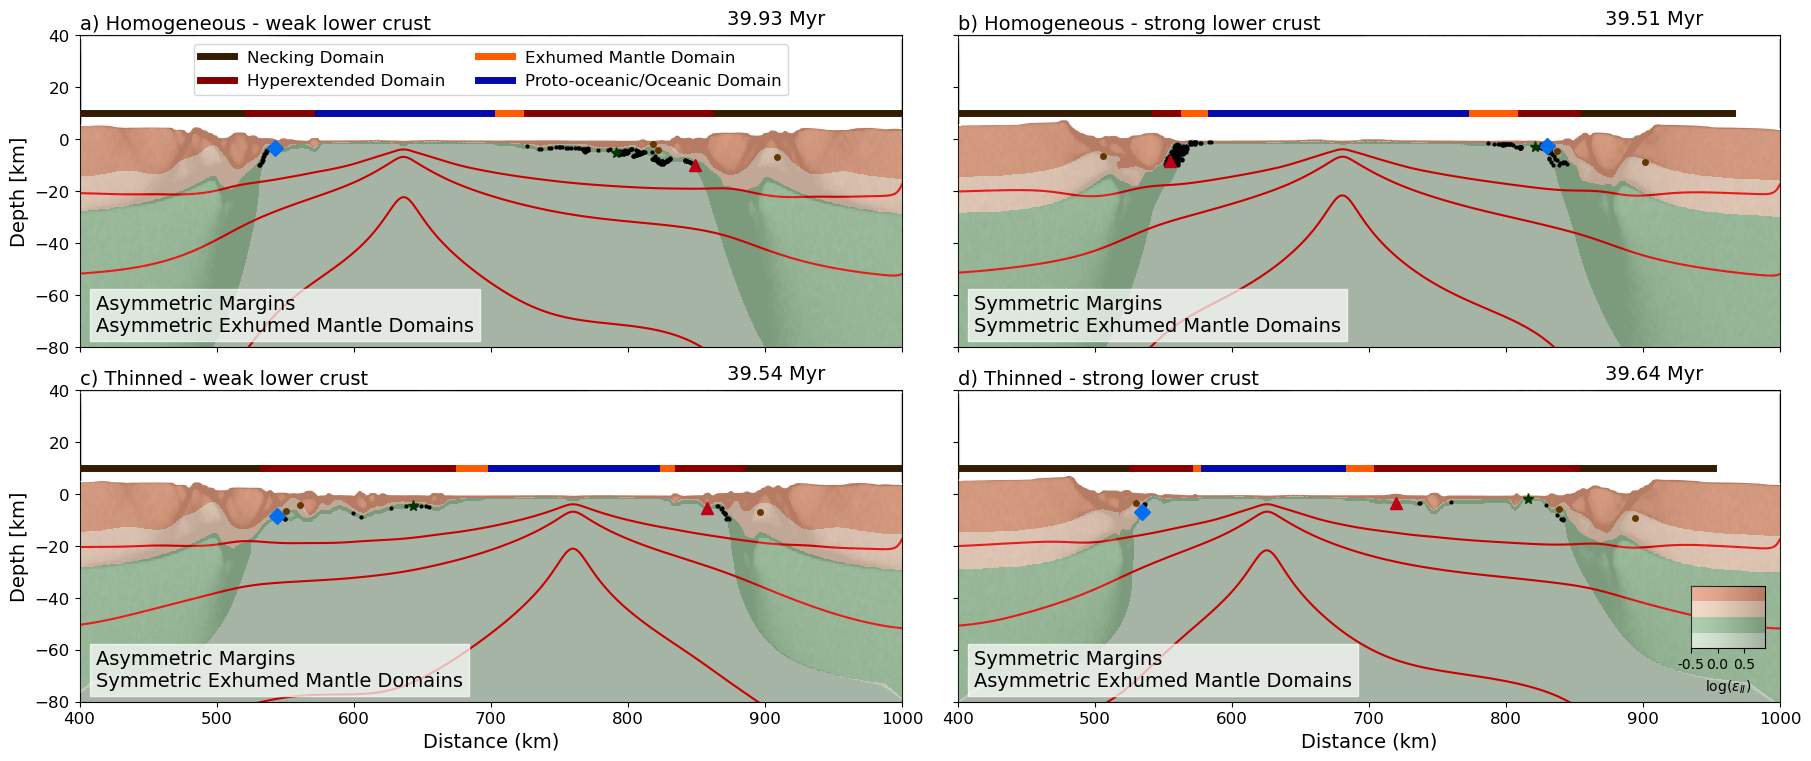

In [20]:
##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'temperature_anomaly'
# prop = 'viscosity'
# prop = 'surface'

# instants = [0, 10., 20., 30.] #Myr

# instants = [34.59, 27.01, 30.54, 33.14] #Myr
if(v==1):
    instants = [40, 40, 40, 40] #Myr

if(v==2):
    instants = [20, 20, 20, 20] #Myr

datasets_list = [dataset0, dataset1, dataset2, dataset3]
trackdatasets_list = [trackdataset0, trackdataset1, trackdataset2, trackdataset3]

plt.close('all')

fig_height = (3.0/2.0)*(len(instants) + 1) #6 minimum
fig = plt.figure(figsize=(18, fig_height), constrained_layout=True)

mosaic = """
         AB
         CD
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.5,
                                                               0.5,
                                                              ]
                                             }
                        )

alphabet = list(string.ascii_uppercase)
axs_idxs = np.asarray(alphabet[0: len(scenarios)]) #starting at A subplot
idxs_aux = axs_idxs.reshape(2,2)

xlims = [400, 1000]
ylims = [-80, 40]
topo_from_density = True
# topo_from_density = False
plot_other_particles = True
# plot_other_particles = False

for instant, dataset, trackdataset, ax_idx in zip(instants, datasets_list, trackdatasets_list, axs_idxs):
    idx = find_nearest(dataset.time, instant)
    plot_colorbar = True if ax_idx == axs_idxs[-1] else False

    plot_property(dataset.isel(time=idx), prop, xlims, ylims, scenarios[0],
             fig,
             axs[ax_idx],
             plot_isotherms = plot_isotherms,
             topo_from_density=topo_from_density,
             plot_particles = False,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=plot_colorbar,
             bbox_to_anchor=(0.9,#horizontal position respective to parent_bbox or "loc" position
                            0.15,# vertical position
                            0.09,# width
                            0.2),
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    plot_tracked_particles(trackdataset, axs[ax_idx], idx, plot_other_particles=plot_other_particles, color_other_particles='xkcd:black', size_other_particles=4)



fsize = 14
##########################
#Set plot details
##########################
#Titles
# axs['A'].set_title(r'Reference Scenario')
axs['A'].text(0.0, 1.02, f"a) Homogeneous - weak lower crust", transform=axs['A'].transAxes, fontsize=14)

# axs['B'].set_title(r'Shifted Cratonic Keel')
axs['B'].text(0.0, 1.02, f"b) Homogeneous - strong lower crust", transform=axs['B'].transAxes, fontsize=14)

# axs['C'].set_title(r'Constant Asthenospheric Drag')
axs['C'].text(0.0, 1.02, f"c) Thinned - weak lower crust", transform=axs['C'].transAxes, fontsize=14)

# axs['D'].set_title(r'Alternating Asthenospheric Drag')
axs['D'].text(0.0, 1.02, f"d) Thinned - strong lower crust", transform=axs['D'].transAxes, fontsize=14)

line_labels = np.asarray(list(string.ascii_lowercase)[0: 4])
label_fsize = 14
for ax_idx in axs_idxs:
    if(ax_idx == axs_idxs[0] or ax_idx == axs_idxs[2]):
        axs[ax_idx].set_ylabel('Depth [km]', fontsize=label_fsize)
    else:
        axs[ax_idx].set_yticklabels([])

    # axs[idxs_aux[i, 0]].text(-0.1, 0.95, f"{line_labels[i]})", transform=axs[idxs_aux[i, 0]].transAxes, fontsize=16)

    if(ax_idx == axs_idxs[-1] or ax_idx == axs_idxs[-2]):
        axs[ax_idx].set_xlabel('Distance (km)', fontsize=label_fsize)
    else:
        axs[ax_idx].set_xticklabels([])


#Drawring horizontal lines of margins domains
def plot_rift_domains(ax, xnecking_left, xnecking_right, xhyper_left, xhyper_right, xexhumed_left, xexhumed_right, xoceanic, z_bar,
                      color_necking = 'xkcd:dark brown',
                      color_hyperextended = 'xkcd:dark red',
                      color_exhumed_mantle = 'xkcd:bright orange',
                      color_oceanic = 'xkcd:cobalt blue',
                      lw=5):
    #Necking domain
    ax.plot(xnecking_left, z_bar, '-', color=color_necking, lw=lw, zorder=90) #left
    ax.plot(xnecking_right, z_bar, '-', color=color_necking, lw=lw, zorder=90) #right

    #Hyperextended domain
    ax.plot(xhyper_left, z_bar, color=color_hyperextended, lw=lw, zorder=90) #left
    ax.plot(xhyper_right, z_bar, color=color_hyperextended, lw=lw, zorder=90) #right

    #Exhumed mantle domain
    ax.plot(xexhumed_left, z_bar, color=color_exhumed_mantle, lw=lw, zorder=90) #left
    ax.plot(xexhumed_right, z_bar, color=color_exhumed_mantle, lw=lw, zorder=90) #right

    #Proto-oceanic/oceanic domain
    ax.plot(xoceanic, z_bar, color=color_oceanic, lw=lw, zorder=90) #left

#Drawing horizontal lines of margins domains
lw = 5
z_bar = [10, 10]
color_necking = 'xkcd:dark brown'
color_hyperextended = 'xkcd:dark red'
color_exhumed_mantle = 'xkcd:bright orange'
color_oceanic = 'xkcd:cobalt blue'

if(v==1):
    #Subplot A
    xli_neckA, xlf_neckA, xil_hyperA, xfl_hyperA, xri_neckA, xrf_neckA, xri_hyperA, xrf_hyperA = get_crustal_domains_coords(dataset0, instants[0], 650)
    xneckingA_left = [xli_neckA, xlf_neckA]
    xneckingA_right = [xri_neckA, xrf_neckA]
    xhyperA_left = [xil_hyperA, xfl_hyperA]
    xhyperA_right = [xri_hyperA, xrf_hyperA]
    xexhumedA_left = [xfl_hyperA, xfl_hyperA]
    xexhumedA_right = [xrf_hyperA, 700]
    xoceanicA = [xfl_hyperA, 700]

    #Subplot B
    xli_neckB, xlf_neckB, xil_hyperB, xfl_hyperB, xri_neckB, xrf_neckB, xri_hyperB, xrf_hyperB = get_crustal_domains_coords(dataset1, instants[1], 700)
    xneckingB_left = [xli_neckB, xlf_neckB]
    xneckingB_right = [xri_neckB, xrf_neckB]
    xhyperB_left = [xil_hyperB, xfl_hyperB]
    xhyperB_right = [xri_hyperB, xrf_hyperB]
    xexhumedB_left = [xfl_hyperB, 585]
    xexhumedB_right = [xrf_hyperB, 770]
    xoceanicB = [585, 770]

    #Subplot C
    xli_neckC, xlf_neckC, xil_hyperC, xfl_hyperC, xri_neckC, xrf_neckC, xri_hyperC, xrf_hyperC = get_crustal_domains_coords(dataset2, instants[2], 750)
    xneckingC_left = [xli_neckC, xlf_neckC]
    xneckingC_right = [xri_neckC, xrf_neckC]
    xhyperC_left = [xil_hyperC, xfl_hyperC]
    xhyperC_right = [xri_hyperC, xrf_hyperC]
    xexhumedC_left = [xfl_hyperC, 700]
    xexhumedC_right = [xrf_hyperC, 820]
    xoceanicC = [700, 820]

    #Subplot D
    xli_neckD, xlf_neckD, xil_hyperD, xfl_hyperD, xri_neckD, xrf_neckD, xri_hyperD, xrf_hyperD = get_crustal_domains_coords(dataset3, instants[3], 650)
    xneckingD_left = [xli_neckD, xlf_neckD]
    xneckingD_right = [xri_neckD, xrf_neckD]
    xhyperD_left = [xil_hyperD, xfl_hyperD]
    xhyperD_right = [xri_hyperD, xrf_hyperD]
    xexhumedD_left = [xfl_hyperD, 580]
    xexhumedD_right = [xrf_hyperD, 680]
    xoceanicD = [580, 680]

if(v==2):
    #Subplot A
    xli_neckA, xlf_neckA, xil_hyperA, xfl_hyperA, xri_neckA, xrf_neckA, xri_hyperA, xrf_hyperA = get_crustal_domains_coords(dataset0, instants[0], 650)
    xneckingA_left = [xli_neckA, xlf_neckA]
    xneckingA_right = [xri_neckA, xrf_neckA]
    xhyperA_left = [xil_hyperA, xfl_hyperA]
    xhyperA_right = [xri_hyperA, xrf_hyperA]
    xexhumedA_left = [xfl_hyperA, 640]
    xexhumedA_right = [xrf_hyperA, 730]
    xoceanicA = [640, 730]

    #Subplot B
    xli_neckB, xlf_neckB, xil_hyperB, xfl_hyperB, xri_neckB, xrf_neckB, xri_hyperB, xrf_hyperB = get_crustal_domains_coords(dataset1, instants[1], 700)
    xneckingB_left = [xli_neckB, xlf_neckB]
    xneckingB_right = [xri_neckB, xrf_neckB]
    xhyperB_left = [xil_hyperB, xfl_hyperB]
    xhyperB_right = [xri_hyperB, xrf_hyperB]
    xexhumedB_left = [xfl_hyperB, 640]
    xexhumedB_right = [xrf_hyperB, 730]
    xoceanicB = [640, 730]

    #Subplot C
    xli_neckC, xlf_neckC, xil_hyperC, xfl_hyperC, xri_neckC, xrf_neckC, xri_hyperC, xrf_hyperC = get_crustal_domains_coords(dataset2, instants[2], 750)
    xneckingC_left = [xli_neckC, xlf_neckC]
    xneckingC_right = [xri_neckC, xrf_neckC]
    xhyperC_left = [xil_hyperC, xfl_hyperC]
    xhyperC_right = [xri_hyperC, xrf_hyperC]
    xexhumedC_left = [xfl_hyperC, 730]
    xexhumedC_right = [xrf_hyperC, 800]
    xoceanicC = [730, 800]

    #Subplot D
    xli_neckD, xlf_neckD, xil_hyperD, xfl_hyperD, xri_neckD, xrf_neckD, xri_hyperD, xrf_hyperD = get_crustal_domains_coords(dataset3, instants[3], 700)
    xneckingD_left = [xli_neckD, xlf_neckD]
    xneckingD_right = [xri_neckD, xrf_neckD]
    xhyperD_left = [xil_hyperD, xfl_hyperD]
    xhyperD_right = [xri_hyperD, xrf_hyperD]
    xexhumedD_left = [xfl_hyperD, 660]
    xexhumedD_right = [xrf_hyperD, 750]
    xoceanicD = [660, 750]

plot_rift_domains(axs['A'], xneckingA_left, xneckingA_right, xhyperA_left, xhyperA_right, xexhumedA_left, xexhumedA_right, xoceanicA, z_bar)
plot_rift_domains(axs['B'], xneckingB_left, xneckingB_right, xhyperB_left, xhyperB_right, xexhumedB_left, xexhumedB_right, xoceanicB, z_bar)
plot_rift_domains(axs['C'], xneckingC_left, xneckingC_right, xhyperC_left, xhyperC_right, xexhumedC_left, xexhumedC_right, xoceanicC, z_bar)
plot_rift_domains(axs['D'], xneckingD_left, xneckingD_right, xhyperD_left, xhyperD_right, xexhumedD_left, xexhumedD_right, xoceanicD, z_bar)

print(f"A: necking left:{xneckingA_left}, hyperextended left:{xhyperA_left}, necking right:{xneckingA_right}, hyperextended right:{xhyperA_right}")
print(f"B: necking left:{xneckingB_left}, hyperextended left:{xhyperB_left}, necking right:{xneckingB_right}, hyperextended right:{xhyperB_right}")
print(f"C: necking left:{xneckingC_left}, hyperextended left:{xhyperC_left}, necking right:{xneckingC_right}, hyperextended right:{xhyperC_right}")
print(f"D: necking left:{xneckingD_left}, hyperextended left:{xhyperD_left}, necking right:{xneckingD_right}, hyperextended right:{xhyperD_right}")

#Bars labels
ax_loc = 'A'
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_necking, lw=lw, zorder=90, label='Necking Domain')
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_hyperextended, lw=lw, zorder=90, label='Hyperextended Domain')
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_exhumed_mantle, lw=lw, zorder=90, label='Exhumed Mantle Domain')
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_oceanic, lw=lw, zorder=90, label='Proto-oceanic/Oceanic Domain')
axs[ax_loc].legend(loc='upper center', ncol=2, fontsize=12).set_zorder(90)

# axs[ax_loc].text(0.02, 0.85, 'Necking Domain', transform=axs[ax_loc].transAxes, fontsize=14, color='xkcd:black', zorder=90)

#Symmetry
alpha=0.7
axs['A'].text(0.02, 0.05, 'Asymmetric Margins\nAsymmetric Exhumed Mantle Domains', transform=axs['A'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['B'].text(0.02, 0.05, 'Symmetric Margins\nSymmetric Exhumed Mantle Domains', transform=axs['B'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['C'].text(0.02, 0.05, 'Asymmetric Margins\nSymmetric Exhumed Mantle Domains', transform=axs['C'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['D'].text(0.02, 0.05, 'Symmetric Margins\nAsymmetric Exhumed Mantle Domains', transform=axs['D'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)

figname = f"RHvsRT_symmetries_v{v}_{prop}"
print(figname)
fig.savefig(f"figures/{figname}.png", dpi=200)
fig.savefig(f"figures/{figname}.pdf", dpi=200)

In [34]:
data = dataset0
Lx = float(data.lx)
Lz = float(data.lz)
Nz = int(data.nz)
Nx = int(data.nx)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(-Lz/1000.0, 0, Nz)
Z = np.linspace(-Lz/1000.0, 0, 8001) #zi

idx = find_nearest(data.time, 20)

Rhoi = data.density.isel(time=idx).values.T

h_air = 40.0
topography_interface = _extract_interface(z, Z, Nx, Rhoi, 200.) + h_air
lower_interface = _extract_interface(z, Z, Nx, Rhoi, 2900.) + h_air
crustal_thickness = np.abs(topography_interface - lower_interface)
x_spread_center = 700

#left margin
cond_left_margin = (x > 0) & (x < x_spread_center)
x_left = x[cond_left_margin]

left_crustal_thickness = crustal_thickness[cond_left_margin]

cond_left_necking = (left_crustal_thickness < 34) & (left_crustal_thickness >= 15)
cond_left_hyperextension = (left_crustal_thickness < 15) & (left_crustal_thickness >= 2)

# right margin
cond_right_margin = (x > x_spread_center) & (x < Lx/1000.0)
x_right = x[cond_right_margin]

right_crustal_thickness = crustal_thickness[cond_right_margin]

cond_right_necking = (right_crustal_thickness < 34) & (right_crustal_thickness >= 15)
cond_right_hyperextension = (right_crustal_thickness < 15) & (right_crustal_thickness >= 2)


print(np.min(crustal_thickness), np.max(crustal_thickness))

2.3625000000000114 34.87500000000003


In [36]:
color_necking = 'xkcd:dark brown'
color_hyperextended = 'xkcd:dark red'
color_exhumed_mantle = 'xkcd:bright orange'
color_oceanic = 'xkcd:cobalt blue'


xi_necking_left0, xf_necking_left0, xi_hyperextended_left0, xf_hyperextended_left0, xi_necking_right0, xf_necking_right0, xi_hyperextended_right0, xf_hyperextended_right0 = get_crustal_domains_coords(dataset0, 20, 650)


plt.close('all')
plt.plot([xi_necking_left0, xf_necking_left0], [10,10], '-', color=color_necking, lw=5, label='Necking Domain')
plt.plot([xi_hyperextended_left0, xf_hyperextended_left0], [10,10], '-', color=color_hyperextended, lw=5, label='Hyperextended Domain')
plt.plot([xi_necking_right0, xf_necking_right0], [10,10], '-', color=color_necking, lw=5)
plt.plot([xi_hyperextended_right0, xf_hyperextended_right0], [10,10], '-', color=color_hyperextended, lw=5)


plt.plot(x, topography_interface, label='Topography Interface')
plt.plot(x, lower_interface, label='Lower Interface')
# plt.plot(x, crustal_thickness, label='Crustal Thickness')
# plt.plot(x_left[cond_left_necking], left_crustal_thickness[cond_left_necking], '.', color=color_necking, label='Necking Domain')
# plt.plot(x_left[cond_left_hyperextension], left_crustal_thickness[cond_left_hyperextension], '.', color=color_hyperextended, label='Hyperextended Domain')

plt.xlim(400, 1000)
plt.legend()

IndexError: index -1 is out of bounds for axis 0 with size 0

In [80]:
xi_necking_left0

378.0

In [13]:
instants, idxs_aux

([0, 15.0, 20.0, 25.0, 30.0],
 array([['A', 'B', 'C', 'D', 'E'],
        ['F', 'G', 'H', 'I', 'J'],
        ['K', 'L', 'M', 'N', 'O'],
        ['P', 'Q', 'R', 'S', 'T']], dtype='<U1'))